In [80]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [81]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from data.processed_mimic.aggregate_mimic import (
    load_mimic_tables, 
    select_labs, 
    aggregate_labs, 
    merge_with_patients_admissions, 
    save_dataset
)

In [83]:
import os
import pandas as pd


raw_path = "../data/raw_mimic/mimic-iv-clinical-database-demo-2.2/hosp"

print("Loading raw MIMIC CSVs...")

patients = pd.read_csv(f"{raw_path}/patients.csv.gz")
admissions = pd.read_csv(f"{raw_path}/admissions.csv.gz")
labevents = pd.read_csv(f"{raw_path}/labevents.csv.gz")
labitems = pd.read_csv(f"{raw_path}/d_labitems.csv.gz")

print("Loaded:")
print("  patients:", patients.shape)
print("  admissions:", admissions.shape)
print("  labevents:", labevents.shape)
print("  labitems:", labitems.shape)

Loading raw MIMIC CSVs...
Loaded:
  patients: (100, 6)
  admissions: (275, 16)
  labevents: (107727, 16)
  labitems: (1622, 4)


In [84]:
list(patients.columns)

['subject_id',
 'gender',
 'anchor_age',
 'anchor_year',
 'anchor_year_group',
 'dod']

In [85]:
list(admissions.columns)

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag']

In [86]:
list(labevents.columns)

['labevent_id',
 'subject_id',
 'hadm_id',
 'specimen_id',
 'itemid',
 'order_provider_id',
 'charttime',
 'storetime',
 'value',
 'valuenum',
 'valueuom',
 'ref_range_lower',
 'ref_range_upper',
 'flag',
 'priority',
 'comments']

In [87]:
list(labitems.columns)

['itemid', 'label', 'fluid', 'category']

In [88]:
df = pd.read_csv("../data/processed_mimic/processed_mimic_24h_labs_demographics.csv")


In [89]:
print(df.shape) 
df.head()

(234, 25)


,subject_id,hadm_id,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag,length_of_stay_hours,ed_wait_time_hours
0,10000032,22595853.0,137.0,4.50,105.0,0.30,25.0,37.6,12.7,NaN,...,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,0,18.866667,4.216667
1,10000032,22841357.0,126.0,5.20,92.0,0.30,29.0,35.5,12.4,13.0,...,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0,24.366667,5.616667
2,10000032,25742920.0,126.0,6.60,94.5,0.60,37.0,34.6,12.1,NaN,...,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,0,42.100000,4.766667
3,10000032,29079034.0,131.0,4.85,102.0,0.45,30.5,34.8,11.9,NaN,...,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0,53.333333,8.100000
4,10001217,27703517.0,142.0,4.10,104.0,0.50,11.0,37.4,12.5,NaN,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,0,141.950000,NaN


In [90]:
lab_vars = [
    "Sodium",
    "Potassium",
    "Chloride",
    "Creatinine",
    "Urea Nitrogen",
    "Hematocrit",
    "Hemoglobin",
    "WBC",
    "Platelet Count",
    "Glucose",
]

demo_vars = [
    "gender",
    "anchor_age",
    "anchor_year_group",
]

adm_vars = [
    "admission_type",
    "admission_location",
    "discharge_location",
    "insurance",
]

severity_vars = [
    "hospital_expire_flag",
    "length_of_stay_hours",
]

all_vars = lab_vars + demo_vars + adm_vars + severity_vars
all_vars = [v for v in all_vars if v in df.columns]  # safety

df_sel = df[all_vars].copy()
print("Selected vars:", df_sel.columns.tolist())
print("Shape:", df_sel.shape)


Selected vars: ['Sodium', 'Potassium', 'Chloride', 'Creatinine', 'Urea Nitrogen', 'Hematocrit', 'Hemoglobin', 'WBC', 'Platelet Count', 'Glucose', 'gender', 'anchor_age', 'anchor_year_group', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'hospital_expire_flag', 'length_of_stay_hours']
Shape: (234, 19)


In [91]:
# Separate continuous vs categorical

cont_vars = [v for v in lab_vars if v in df_sel.columns] + [
    v for v in ["anchor_age", "length_of_stay_hours"] if v in df_sel.columns
]

cat_vars = [v for v in df_sel.columns if v not in cont_vars]

print("Continuous:", cont_vars)
print("Categorical:", cat_vars)


Continuous: ['Sodium', 'Potassium', 'Chloride', 'Creatinine', 'Urea Nitrogen', 'Hematocrit', 'Hemoglobin', 'WBC', 'Platelet Count', 'Glucose', 'anchor_age', 'length_of_stay_hours']
Categorical: ['gender', 'anchor_year_group', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'hospital_expire_flag']


In [92]:
# Encode categoricals (one‑hot) and standardize continuous

from sklearn.preprocessing import StandardScaler

# Continuous
df_cont = df_sel[cont_vars].copy()

scaler = StandardScaler()
df_cont_scaled = pd.DataFrame(
    scaler.fit_transform(df_cont),
    columns=cont_vars,
    index=df_sel.index,
)

# Categorical → one‑hot (including NaN as its own category)
df_cat = df_sel[cat_vars].copy()
df_cat_oh = pd.get_dummies(df_cat, columns=cat_vars, dummy_na=True)

# Combine
df_encoded = pd.concat([df_cont_scaled, df_cat_oh], axis=1)

print("Encoded shape:", df_encoded.shape)
df_encoded.head()


Encoded shape: (234, 56)


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,...,discharge_location_REHAB,discharge_location_SKILLED NURSING FACILITY,discharge_location_nan,insurance_Medicaid,insurance_Medicare,insurance_Other,insurance_nan,hospital_expire_flag_0.0,hospital_expire_flag_1.0,hospital_expire_flag_nan
0,-0.104883,0.637136,0.543916,-0.691789,-0.019601,0.800597,0.942301,NaN,-1.366815,-0.658077,...,False,False,False,False,False,True,False,True,False,False
1,-2.463596,1.846079,-1.747998,-0.691789,0.175556,0.435090,0.795752,-0.205025,-0.786248,-1.084029,...,False,False,False,True,False,False,False,True,False,False
2,-2.463596,4.263966,-1.307246,-0.521476,0.565871,0.278444,0.649203,NaN,-0.821434,-0.718927,...,False,False,False,True,False,False,False,True,False,False
3,-1.391454,1.241607,0.015013,-0.606632,0.248740,0.313254,0.551504,NaN,-1.164496,-0.475526,...,False,False,False,True,False,False,False,True,False,False
4,0.967259,-0.053689,0.367615,-0.578247,-0.702651,0.765787,0.844602,NaN,0.656373,-0.840628,...,False,False,False,False,False,True,False,True,False,False


In [93]:
# Expanded variable set (19 variables)
mvpc_vars = [
    # Labs
    "Sodium", "Potassium", "Chloride", "Creatinine", "Urea Nitrogen",
    "Hematocrit", "Hemoglobin", "WBC", "Platelet Count", "Glucose",

    # Demographics
    "gender", "anchor_age", "anchor_year_group",

    # Admission context
    "admission_type", "admission_location", "discharge_location", "insurance",

    # Severity
    "hospital_expire_flag", "length_of_stay_hours",
]

# Keep only variables that exist in the dataset
mvpc_vars = [v for v in mvpc_vars if v in df.columns]

df_mvpc = df[mvpc_vars].copy()
print("Using variables:", df_mvpc.columns.tolist())
print("Shape:", df_mvpc.shape)



Using variables: ['Sodium', 'Potassium', 'Chloride', 'Creatinine', 'Urea Nitrogen', 'Hematocrit', 'Hemoglobin', 'WBC', 'Platelet Count', 'Glucose', 'gender', 'anchor_age', 'anchor_year_group', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'hospital_expire_flag', 'length_of_stay_hours']
Shape: (234, 19)


In [94]:
from sklearn.preprocessing import StandardScaler

# Identify continuous variables
cont_vars = [
    "Sodium", "Potassium", "Chloride", "Creatinine", "Urea Nitrogen",
    "Hematocrit", "Hemoglobin", "WBC", "Platelet Count", "Glucose",
    "anchor_age", "length_of_stay_hours",
]

cont_vars = [v for v in cont_vars if v in df_mvpc.columns]

# Categorical = everything else
cat_vars = [v for v in df_mvpc.columns if v not in cont_vars]

# Standardize continuous
df_cont = df_mvpc[cont_vars]
scaler = StandardScaler()
df_cont_scaled = pd.DataFrame(
    scaler.fit_transform(df_cont),
    columns=cont_vars,
    index=df_mvpc.index,
)

# One-hot encode categorical
df_cat = pd.get_dummies(df_mvpc[cat_vars], dummy_na=True)

# Combine
df_encoded = pd.concat([df_cont_scaled, df_cat], axis=1)
print("Encoded shape:", df_encoded.shape)


Encoded shape: (234, 54)


In [95]:
df_encoded = df_encoded.astype(float)


In [96]:
X_complete = df_encoded.values
num_var = X_complete.shape[1]
print("Final MVPC matrix shape:", X_complete.shape)



Final MVPC matrix shape: (234, 54)


In [97]:
from data.synthetic_data_generation.dag_and_data import (
    random_dag, detect_colliders, detect_collider_parents
)
from data.synthetic_data_generation.missingness_synthetic import (
    create_mar_ind, create_mnar_ind,
    generate_missing_values, generate_mcar_reference
)

num_var = X_complete.shape[1]

# 1. Random DAG over these 12 variables
G, adj = random_dag(n_nodes=num_var, seed=42)
colliders = detect_colliders(adj)
collider_parents = detect_collider_parents(adj, colliders)

print("Adjacency matrix:\n", adj)
print("Colliders:", colliders)
print("Collider parents:", collider_parents)

# 2. MAR
ms_mar, prt_ms_mar = create_mar_ind(
    colliders=colliders,
    collider_parents=collider_parents,
    num_var=num_var,
    num_extra_e=3,
    num_m=6,
    seed=42,
)

X_mar = generate_missing_values(
    X_complete=X_complete,
    ms=ms_mar,
    prt_ms=prt_ms_mar,
    p_missing_h=0.9,
    p_missing_l=0.1,
    seed=42,
)

# 3. MCAR reference
X_mcar = generate_mcar_reference(
    X_complete=X_complete,
    X_mar=X_mar,
    ms=ms_mar,
    seed=42,
)

# 4. MNAR
ms_mnar, prt_ms_mnar = create_mnar_ind(
    colliders=colliders,
    collider_parents=collider_parents,
    num_var=num_var,
    num_extra_e=3,
    num_m=6,
    seed=42,
)

X_mnar = generate_missing_values(
    X_complete=X_complete,
    ms=ms_mnar,
    prt_ms=prt_ms_mnar,
    p_missing_h=0.9,
    p_missing_l=0.1,
    seed=42,
)


Adjacency matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Colliders: [7, 16, 19, 20, 22, 25, 26, 31, 32, 36, 39, 41, 42, 43, 44, 49, 50, 53]
Collider parents: [[np.int64(4), np.int64(14), np.int64(29), np.int64(35)], [np.int64(6), np.int64(53)], [np.int64(3), np.int64(24), np.int64(40)], [np.int64(8), np.int64(25), np.int64(29), np.int64(33), np.int64(52)], [np.int64(24), np.int64(33)], [np.int64(9), np.int64(48)], [np.int64(2), np.int64(47)], [np.int64(13), np.int64(25)], [np.int64(23), np.int64(34), np.int64(35)], [np.int64(5), np.int64(6), np.int64(47)], [np.int64(18), np.int64(53)], [np.int64(5), np.int64(10), np.int64(11), np.int64(34)], [np.int64(5), np.int64(36)], [np.int64(0), np.int64(2), np.int64(4), np.int64(13), np.int64(37)], [np.int64(21), np.int64(30)], [np.int64(1), np.int64(20)], [np.int64(25), np.int64(52)], [np.int64(3), np.int64(45)]]


In [99]:
cols_encoded = df_encoded.columns

pd.DataFrame(X_mar,  columns=cols_encoded).to_csv("../data/processed_mimic/mimic_mar_v2.csv",  index=False)
pd.DataFrame(X_mnar, columns=cols_encoded).to_csv("../data/processed_mimic/mimic_mnar_v2.csv", index=False)
pd.DataFrame(X_mcar, columns=cols_encoded).to_csv("../data/processed_mimic/mimic_mcar_v2.csv", index=False)



In [100]:
df_mar  = pd.read_csv("../data/processed_mimic/mimic_mar_v2.csv")
df_mnar = pd.read_csv("../data/processed_mimic/mimic_mnar_v2.csv")
df_mcar = pd.read_csv("../data/processed_mimic/mimic_mcar_v2.csv")

X_mar  = df_mar.values
X_mnar = df_mnar.values
X_mcar = df_mcar.values


In [101]:
# SHD helper 
def shd_skeleton(G_est, G_true):
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)
    return np.sum(G_est_sym != G_true_sym)

In [102]:
def f1_skeleton(G_est, G_true):
    # symmetrize
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)

    # vectorize upper triangle only (avoid double counting)
    triu_idx = np.triu_indices_from(G_true_sym, k=1)

    est = G_est_sym[triu_idx]
    true = G_true_sym[triu_idx]

    TP = np.sum((est == 1) & (true == 1))
    FP = np.sum((est == 1) & (true == 0))
    FN = np.sum((est == 0) & (true == 1))

    if TP + FP == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)


In [103]:
from data.synthetic_data_generation.dag_and_data import (
    random_dag, detect_colliders, detect_collider_parents
)

num_var = X_mar.shape[1]   # number of variables in your dataset
seed = 42                  # must match the seed used during missingness generation

# Recreate the DAG
G, adj_true = random_dag(n_nodes=num_var, seed=seed)
colliders = detect_colliders(adj_true)
collider_parents = detect_collider_parents(adj_true, colliders)

print("adj_true shape:", adj_true.shape)
print("Colliders:", colliders)
print("Collider parents:", collider_parents)


adj_true shape: (54, 54)
Colliders: [7, 16, 19, 20, 22, 25, 26, 31, 32, 36, 39, 41, 42, 43, 44, 49, 50, 53]
Collider parents: [[np.int64(4), np.int64(14), np.int64(29), np.int64(35)], [np.int64(6), np.int64(53)], [np.int64(3), np.int64(24), np.int64(40)], [np.int64(8), np.int64(25), np.int64(29), np.int64(33), np.int64(52)], [np.int64(24), np.int64(33)], [np.int64(9), np.int64(48)], [np.int64(2), np.int64(47)], [np.int64(13), np.int64(25)], [np.int64(23), np.int64(34), np.int64(35)], [np.int64(5), np.int64(6), np.int64(47)], [np.int64(18), np.int64(53)], [np.int64(5), np.int64(10), np.int64(11), np.int64(34)], [np.int64(5), np.int64(36)], [np.int64(0), np.int64(2), np.int64(4), np.int64(13), np.int64(37)], [np.int64(21), np.int64(30)], [np.int64(1), np.int64(20)], [np.int64(25), np.int64(52)], [np.int64(3), np.int64(45)]]


In [104]:
from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

def run_mvpc_all_methods(X_m, adj_true):
    results = {}

    # TD-PC
    mvpc_td = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
    G_td = mvpc_td.run(X_m)["G_corrected"]
    results["TD"] = {
        "shd": shd_skeleton(G_td, adj_true),
        "f1": f1_skeleton(G_td, adj_true),
    }

    # PermC
    mvpc_permc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
    G_permc = mvpc_permc.run(X_m)["G_corrected"]
    results["PERMC"] = {
        "shd": shd_skeleton(G_permc, adj_true),
        "f1": f1_skeleton(G_permc, adj_true),
    }

    # DRW
    mvpc_drw = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)
    G_drw = mvpc_drw.run(X_m)["G_corrected"]
    results["DRW"] = {
        "shd": shd_skeleton(G_drw, adj_true),
        "f1": f1_skeleton(G_drw, adj_true),
    }

    return results


In [105]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from data.synthetic_data_generation.synthetic_generator import gen_data

from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw




In [106]:
results_mimic = {
    "MAR":  run_mvpc_all_methods(X_mar,  adj_true),
    "MNAR": run_mvpc_all_methods(X_mnar, adj_true),
    "MCAR": run_mvpc_all_methods(X_mcar, adj_true),
}

results_mimic


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31), np.int64(47), np.int64(52)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2)]


Detecting parents of missingness indicators:  64%|██████▍   | 9/14 [00:00<00:00, 89.25it/s]

[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(31), np.int64(39)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=39, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 103.79it/s]


[Step 1] R_ind=46, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 11, 30, 39]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31), np.int64(47), np.int64(52)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2)], 9: [np.int64(19)], 11: [np.int64(31), np.int64(39)], 30: [np.int64(40)], 39: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31), np.int64(47), np.int64(52)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(31), np.int64(39)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=39, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 145.55it/s]


[Step 1] R_ind=46, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 11, 30, 39]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31), np.int64(47), np.int64(52)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2)], 9: [np.int64(19)], 11: [np.int64(31), np.int64(39)], 30: [np.int64(40)], 39: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31), np.int64(47), np.int64(52)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(31), np.int64(39)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=39, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 176.74it/s]


[Step 1] R_ind=46, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 11, 30, 39]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31), np.int64(47), np.int64(52)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2)], 9: [np.int64(19)], 11: [np.int64(31), np.int64(39)], 30: [np.int64(40)], 39: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 26, 30, 41, 44]


Detecting parents of missingness indicators:   0%|          | 0/15 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2), np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=26, parents=[np.int64(6)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=41, parents=[np.int64(27)]


Detecting parents of missingness indicators: 100%|██████████| 15/15 [00:00<00:00, 184.03it/s]


[Step 1] R_ind=44, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 26, 30, 41]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2), np.int64(50)], 9: [np.int64(19)], 26: [np.int64(6)], 30: [np.int64(40)], 41: [np.int64(27)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 26, 30, 41, 44]


Detecting parents of missingness indicators:   0%|          | 0/15 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2), np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=26, parents=[np.int64(6)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=41, parents=[np.int64(27)]


Detecting parents of missingness indicators: 100%|██████████| 15/15 [00:00<00:00, 148.84it/s]


[Step 1] R_ind=44, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 26, 30, 41]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2), np.int64(50)], 9: [np.int64(19)], 26: [np.int64(6)], 30: [np.int64(40)], 41: [np.int64(27)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 26, 30, 41, 44]


Detecting parents of missingness indicators:   0%|          | 0/15 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(26), np.int64(31)]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(2), np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=26, parents=[np.int64(6)]


[Step 1] R_ind=30, parents=[np.int64(40)]


[Step 1] R_ind=41, parents=[np.int64(27)]


Detecting parents of missingness indicators: 100%|██████████| 15/15 [00:00<00:00, 184.62it/s]


[Step 1] R_ind=44, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 5, 6, 7, 9, 26, 30, 41]
[Step 1] prt dict: {2: [np.int64(26), np.int64(31)], 3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(2), np.int64(50)], 9: [np.int64(19)], 26: [np.int64(6)], 30: [np.int64(40)], 41: [np.int64(27)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=30, parents=[np.int64(1), np.int64(10)]


[Step 1] R_ind=39, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 197.85it/s]


[Step 1] R_ind=46, parents=[np.int64(22), np.int64(47)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 6, 7, 9, 30, 46]
[Step 1] prt dict: {3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(50)], 9: [np.int64(19)], 30: [np.int64(1), np.int64(10)], 46: [np.int64(22), np.int64(47)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=30, parents=[np.int64(1), np.int64(10)]


[Step 1] R_ind=39, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 192.99it/s]


[Step 1] R_ind=46, parents=[np.int64(22), np.int64(47)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 6, 7, 9, 30, 46]
[Step 1] prt dict: {3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(50)], 9: [np.int64(19)], 30: [np.int64(1), np.int64(10)], 46: [np.int64(22), np.int64(47)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 39, 46]


Detecting parents of missingness indicators:   0%|          | 0/14 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(52)]


[Step 1] R_ind=4, parents=[np.int64(52)]


[Step 1] R_ind=5, parents=[np.int64(21)]


[Step 1] R_ind=6, parents=[np.int64(19), np.int64(21)]


[Step 1] R_ind=7, parents=[np.int64(50)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[]


[Step 1] R_ind=30, parents=[np.int64(1), np.int64(10)]


[Step 1] R_ind=39, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 14/14 [00:00<00:00, 126.69it/s]


[Step 1] R_ind=46, parents=[np.int64(22), np.int64(47)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 6, 7, 9, 30, 46]
[Step 1] prt dict: {3: [np.int64(52)], 4: [np.int64(52)], 5: [np.int64(21)], 6: [np.int64(19), np.int64(21)], 7: [np.int64(50)], 9: [np.int64(19)], 30: [np.int64(1), np.int64(10)], 46: [np.int64(22), np.int64(47)]}


{'MAR': {'TD': {'shd': np.int64(226), 'f1': np.float64(0.06611570247933884)},
  'PERMC': {'shd': np.int64(226), 'f1': np.float64(0.06611570247933884)},
  'DRW': {'shd': np.int64(226), 'f1': np.float64(0.06611570247933884)}},
 'MNAR': {'TD': {'shd': np.int64(204), 'f1': np.float64(0.07272727272727272)},
  'PERMC': {'shd': np.int64(204), 'f1': np.float64(0.07272727272727272)},
  'DRW': {'shd': np.int64(204), 'f1': np.float64(0.07272727272727272)}},
 'MCAR': {'TD': {'shd': np.int64(220), 'f1': np.float64(0.06779661016949153)},
  'PERMC': {'shd': np.int64(220), 'f1': np.float64(0.06779661016949153)},
  'DRW': {'shd': np.int64(220), 'f1': np.float64(0.06779661016949153)}}}

In [107]:
import pandas as pd

rows = []
for mode, methods in results_mimic.items():
    for method, metrics in methods.items():
        rows.append({
            "mode": mode,
            "method": method,
            "shd": float(metrics["shd"]),
            "f1": float(metrics["f1"]),
        })

df_mimic_results = pd.DataFrame(rows)
df_mimic_results


,mode,method,shd,f1
0,MAR,TD,226.0,0.066116
1,MAR,PERMC,226.0,0.066116
2,MAR,DRW,226.0,0.066116
3,MNAR,TD,204.0,0.072727
4,MNAR,PERMC,204.0,0.072727
5,MNAR,DRW,204.0,0.072727
6,MCAR,TD,220.0,0.067797
7,MCAR,PERMC,220.0,0.067797
8,MCAR,DRW,220.0,0.067797


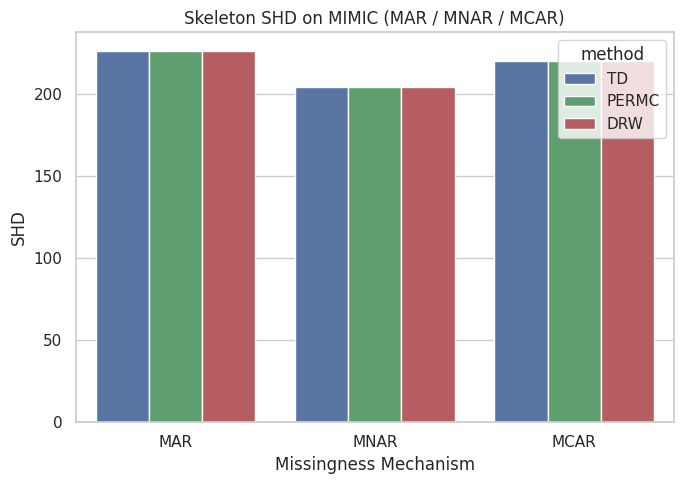

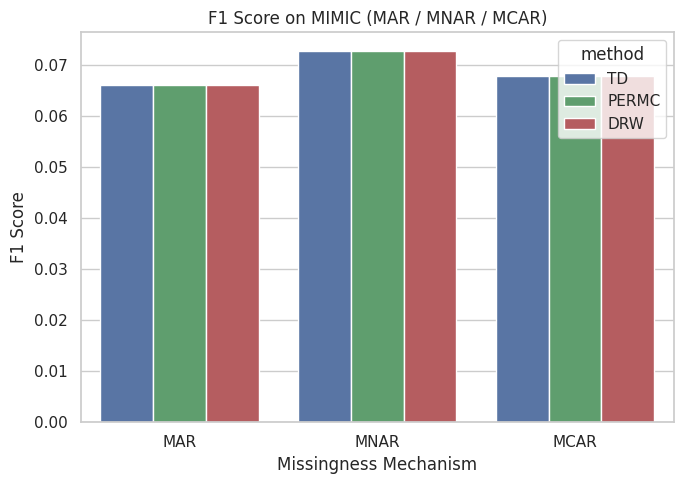

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(7,5))
sns.barplot(
    data=df_mimic_results,
    x="mode",
    y="shd",
    hue="method",
    palette=["#4C72B0", "#55A868", "#C44E52"]
)
plt.title("Skeleton SHD on MIMIC (MAR / MNAR / MCAR)")
plt.xlabel("Missingness Mechanism")
plt.ylabel("SHD")
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,5))
sns.barplot(
    data=df_mimic_results,
    x="mode",
    y="f1",
    hue="method",
    palette=["#4C72B0", "#55A868", "#C44E52"]
)
plt.title("F1 Score on MIMIC (MAR / MNAR / MCAR)")
plt.xlabel("Missingness Mechanism")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()
